In [1]:
import torch
import torch.nn as nn
from torchview import draw_graph
from einops import rearrange
from tqdm import tqdm
import torch.nn.functional  as Fn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.optim as optim


Implementation
https://www.youtube.com/watch?v=1mi2MSvigcc&t=18s

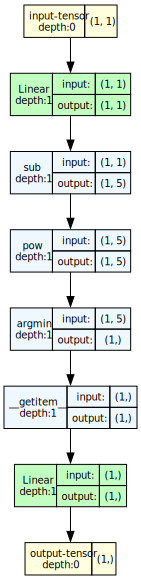

In [2]:
class VQVAEQuantizeWithoutDerivative(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(1, 1)
        self.codebook = nn.Parameter(torch.tensor([-5., -9., 0., 6., 9.]))
        self.decoder = nn.Linear(1, 1)

    def forward(self, x):
        encoder_out = self.encoder(x)
        l2_difference = (encoder_out - self.codebook) ** 2
        nearest_index = torch.argmin(l2_difference, dim = -1)
        # print(nearest_index)
        decoder_input = self.codebook[nearest_index]
        # print(decoder_input)
        decoder_out = self.decoder(decoder_input)
        return decoder_out

q = VQVAEQuantizeWithoutDerivative()
test = torch.ones(1).unsqueeze(0)
out = q(test)
# print(out)
out.backward()
model_graph = draw_graph(q, input_size = (1, 1))
model_graph.visual_graph

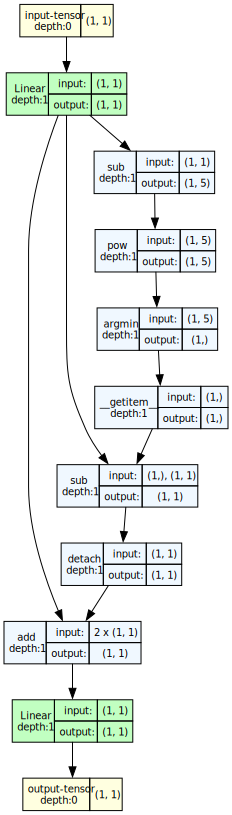

In [3]:
class VQVAEQuantizeWithDerivative(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(1, 1)
        self.codebook = nn.Parameter(torch.tensor([-5., -9., 0., 6., 9.]))
        self.decoder = nn.Linear(1, 1)

    def forward(self, x):
        encoder_out = self.encoder(x)
        l2_difference = (encoder_out - self.codebook) ** 2
        nearest_index = torch.argmin(l2_difference, dim = -1)
        # print(nearest_index)
        decoder_input = self.codebook[nearest_index]
        # print(decoder_input)
        decoder_input = encoder_out + (decoder_input - encoder_out).detach()
        decoder_out = self.decoder(decoder_input)
        return decoder_out

q = VQVAEQuantizeWithDerivative()
test = torch.ones(1).unsqueeze(0)
out = q(test)
# print(out)
out.backward()
model_graph = draw_graph(q, input_size = (1, 1))
model_graph.visual_graph

In [4]:
class VecQVAE(nn.Module):
    def __init__(self, inChannels = 1, hiddenDim = 256, codeBookdim = 256, embedDim = 128):
        super().__init__()

        self.inChannels = inChannels
        self.codeBookdim = codeBookdim
        self.embedDim = embedDim

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=inChannels, out_channels=hiddenDim, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hiddenDim, out_channels=embedDim, kernel_size=3, stride=2, padding=1)
        )
        self.codebook = nn.Embedding(num_embeddings=codeBookdim, embedding_dim=embedDim)
        nn.init.uniform_(self.codebook.weight, -1.0 / codeBookdim, 1.0 / codeBookdim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=embedDim, out_channels=hiddenDim, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=hiddenDim, out_channels=inChannels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        batch, channels, height, width = x.shape
        encoderOut = self.encoder(x)
        encoder_reshaped = rearrange(encoderOut, 'b d h w -> b (h w) d')

        # print(encoder_reshaped.shape)
        # l2_difference = (encoder_reshaped - self.codebook.weight.unsqueeze(0)) ** 2
        l2_difference = (
            torch.sum(encoder_reshaped ** 2, dim=2, keepdim=True)
            - 2 * torch.matmul(encoder_reshaped, self.codebook.weight.t())
            + torch.sum(self.codebook.weight.t() ** 2, dim=0, keepdim=True)
        )

        encoded_indices = torch.argmin(l2_difference, dim = -1)
        quantized = self.codebook(encoded_indices)

        quantized = encoder_reshaped + (quantized - encoder_reshaped).detach()

        decoderOut = rearrange(quantized, 'b (h w) d -> b d h w', h=encoderOut.shape[2], w=encoderOut.shape[3])
        # print(decoderOut.shape)
        output = self.decoder(decoderOut)
    
        return output, encoderOut, decoderOut, encoded_indices
    
VQ = VecQVAE()
test = torch.randn(1, 1, 64, 64)
out, ez, qz, indices = VQ(test)
out.shape, ez.shape, qz.shape, indices.shape

(torch.Size([1, 1, 64, 64]),
 torch.Size([1, 128, 16, 16]),
 torch.Size([1, 128, 16, 16]),
 torch.Size([1, 256]))

In [5]:
def VecQVAELoss(inputImage, outputImage, encoderOut, decoderOut, betaValue = 0.25):

    reconstruction_loss = Fn.mse_loss(outputImage, inputImage)
    codeBook_loss = Fn.mse_loss(decoderOut.detach(), encoderOut)
    commitment_loss = Fn.mse_loss(encoderOut.detach(), decoderOut)
    lossValue = reconstruction_loss + codeBook_loss + betaValue * commitment_loss
    return lossValue

inpImage = torch.randn(1, 1, 64, 64)
lsFn = VecQVAELoss(inpImage, out, ez, qz)
lsFn.item()

1.350877046585083

In [6]:
class Transformer(nn.Module):
    def __init__(self, vocab_size=512, seq_length = 10, embed_dim=256, num_heads=4, feed_forward_dim=512):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.seq_length = seq_length
        
        self.positional_encoding = nn.Parameter(torch.randn(1, seq_length, embed_dim, embed_dim))
        
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=feed_forward_dim,
            dropout=0.1,
            batch_first=True  # Use batch-first format
        )
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        
        self.output_layer = nn.Linear(embed_dim, 1)

    def forward(self, x):
        
        batch, features = x.shape
        x = rearrange(x, 'b (s e) -> b s e', e = self.embed_dim, s = self.seq_length)
        x = self.embedding(x)
        
        x = x + self.positional_encoding
        x = rearrange(x, 'b s e d -> b (s e) d', e = self.embed_dim, s = self.seq_length)
        x = self.encoder(x)
        x = self.output_layer(x)
        
        x = rearrange(x, 'b s e -> b (s e)')
        
        return x

 
tr = Transformer()
test = torch.randint(0, 10, (2, 2560))

out = tr(test)
print(out.shape)

torch.Size([2, 2560])


In [7]:
class MakeVideoDataset(Dataset):
    def __init__(self, video, input_length=10, output_length=10):
        super().__init__()
        self.video = video
        self.input_length = input_length
        self.output_length = output_length
        self.batch_size, self.seq_len, _, _, _ = video.shape

        self.samples_per_video = self.seq_len - input_length - output_length + 1
        self.total_samples = self.batch_size * self.samples_per_video

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        batch_idx = idx // self.samples_per_video
        time_idx = idx % self.samples_per_video

        input_frames = self.video[batch_idx, time_idx:time_idx + self.input_length]
        output_frames = self.video[batch_idx, time_idx + self.input_length:time_idx + self.input_length + self.output_length]

        return (
            torch.tensor(input_frames, dtype=torch.float32),
            torch.tensor(output_frames, dtype=torch.float32)
        )

    
    
test = torch.randn(32, 20, 1, 4, 4)
out = MakeVideoDataset(test)
x, y = out.__getitem__(0)
x.shape, y.shape

/var/folders/y8/q2s37ndx6tg3lpzp3vp8xk_r0000gn/T/ipykernel_11585/2549432269.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(input_frames, dtype=torch.float32),
/var/folders/y8/q2s37ndx6tg3lpzp3vp8xk_r0000gn/T/ipykernel_11585/2549432269.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(output_frames, dtype=torch.float32)


(torch.Size([10, 1, 4, 4]), torch.Size([10, 1, 4, 4]))

In [8]:
data = np.load("data/MovingMNIST/mnist_test_seq.npy")
print(data.shape)
data = np.transpose(data, (1, 0, 2, 3))
data = torch.from_numpy(data)
data = data.unsqueeze(2)
data.shape

(20, 10000, 64, 64)


torch.Size([10000, 20, 1, 64, 64])

In [20]:
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
torchDataset = MakeVideoDataset(data)
dataloader = DataLoader(torchDataset, batch_size=8, shuffle = True)

transformer_celoss =nn.CrossEntropyLoss()
modelA = Transformer().to(device)
modelB = VecQVAE().to(device)

optimizerA = optim.AdamW(modelA.parameters(), lr=5e-5)
optimizerB = optim.Adam(modelB.parameters(), lr=2e-4)

epochs = 50

In [23]:
for each_epoch in range(epochs):

    loop = tqdm(dataloader, f"{each_epoch}/{epochs}")
    for datapoint in loop:
        # print(datapoint[0].shape, datapoint[1].shape)
        datapoint[0] = datapoint[0]/255.0
        datapoint[1] = datapoint[1]/255.0

        input_indices = []
        output_indices = []
        vqvaeloss = 0.0
        transformer_loss = 0.0
        totalLoss = 0.0

        for each_frame_index in range(datapoint[0].shape[1]):
            each_input_frame = datapoint[0][:, each_frame_index, ...]
            out, ez, qz, inputindex = modelB(each_input_frame)
            vqvaeloss += VecQVAELoss(each_input_frame, out, ez, qz)

            each_output_frame = datapoint[1][:, each_frame_index, ...]
            out, ez, qz, outputindex = modelB(each_input_frame)
            vqvaeloss += VecQVAELoss(each_input_frame, out, ez, qz)

            input_indices.append(inputindex)
            output_indices.append(outputindex)

        # print(vqvaeloss)
        inputCodeboobIndices = torch.cat(input_indices, dim=-1)
        outputCodeboobIndices = torch.cat(output_indices, dim=-1)

        # print(inputCodeboobIndices.shape)
        predX = modelA(inputCodeboobIndices)
        # y = modelA(outputCodeboobIndices)
        # print(predX.shape, inputCodeboobIndices.shape, outputCodeboobIndices.shape)
        
        predX = rearrange(predX, 'b (d l) -> b d l', l = 10)
        outputCodeboobIndices = rearrange(outputCodeboobIndices, 'b (d l) -> b d l', l = 10)

        loss = transformer_celoss(predX, outputCodeboobIndices.float())
        # # transformer_loss += loss.item()

        combined_loss = loss + vqvaeloss
        

        optimizerA.zero_grad()
        optimizerB.zero_grad()

        combined_loss.backward()

        optimizerA.step()
        optimizerB.step()

        loop.set_postfix({"VQVAE Loss": f"{vqvaeloss.item()}", " Transformer Loss": f"{loss.item()}", " Total Loss": f"{combined_loss.item()}"
})
    
    if each_epoch % 5 == 0:
        torch.save(modelA.state_dict(), "model/VQVAE/transformer.pt")
        torch.save(modelB.state_dict(), "model/VQVAE/vqvae.pt")

    

0/50:   0%|          | 0/1250 [00:00<?, ?it/s]/var/folders/y8/q2s37ndx6tg3lpzp3vp8xk_r0000gn/T/ipykernel_11585/2549432269.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(input_frames, dtype=torch.float32),
/var/folders/y8/q2s37ndx6tg3lpzp3vp8xk_r0000gn/T/ipykernel_11585/2549432269.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(output_frames, dtype=torch.float32)
0/50:   0%|          | 0/1250 [00:05<?, ?it/s]


KeyboardInterrupt: 